# **Advanced AI Applications**
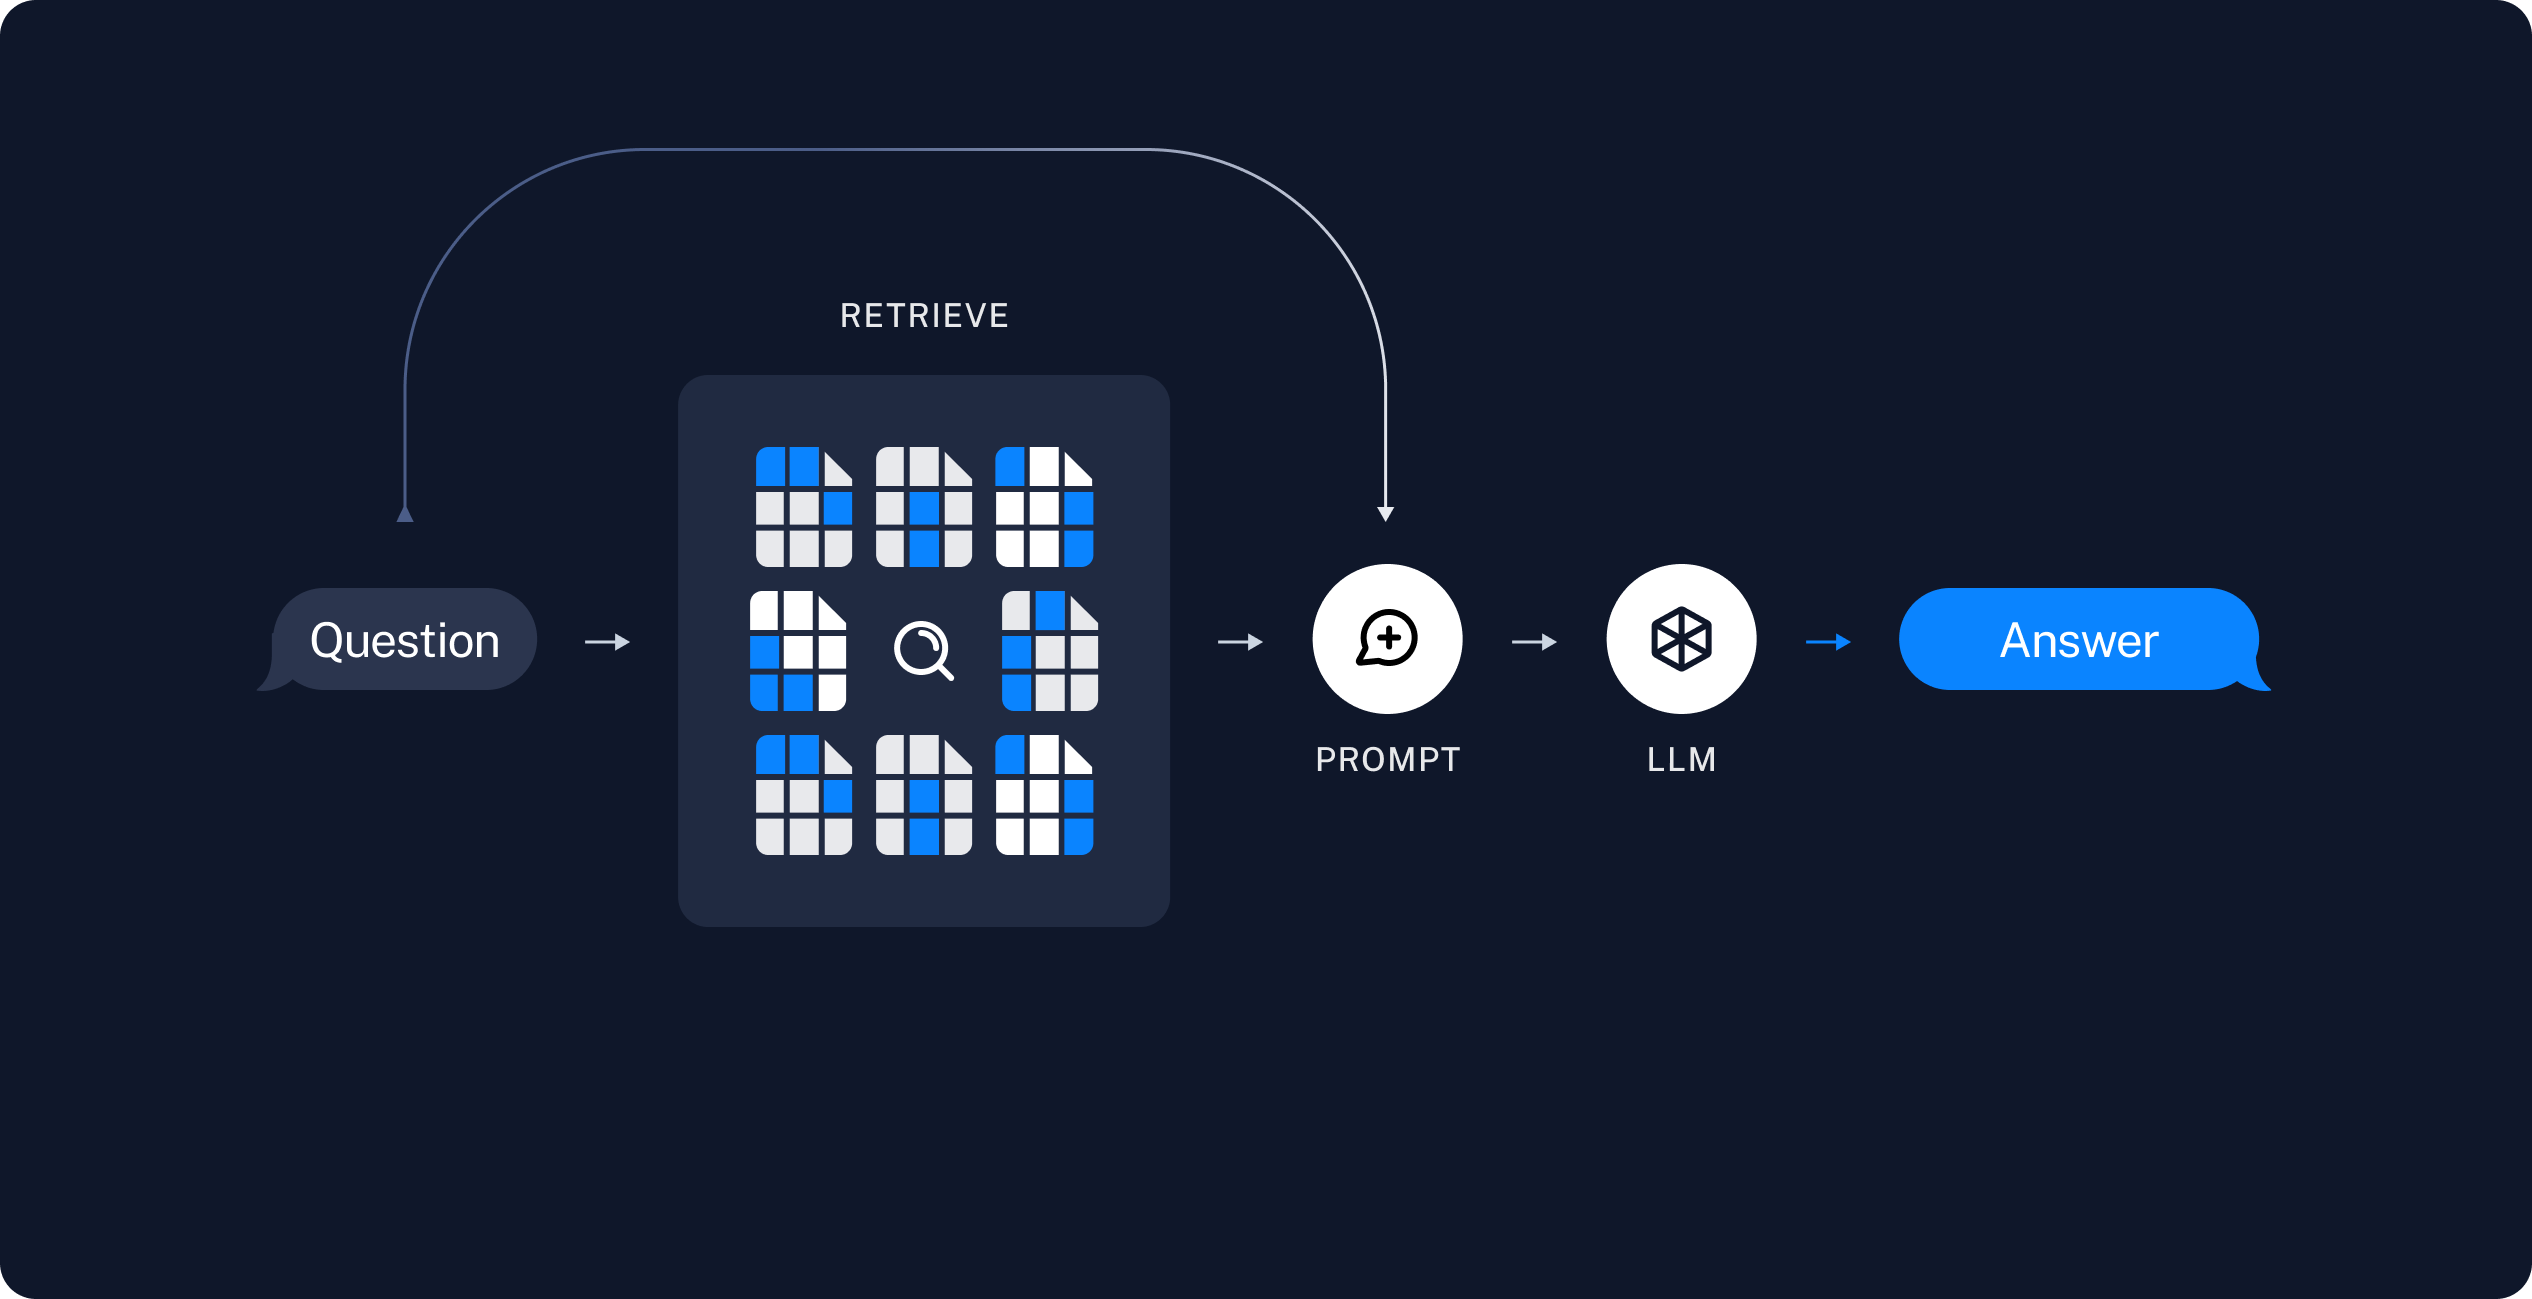

## Group members
* Benjamin Ly - 20205432
* Camilla Dyg Hannesbo - 20202923
* Tobias Moesgård Jensen - 20231658

# Introduction
This assignment is designed to explore the frontier of AI applications, focusing on the integration of Retrieval-Augmented Generation (RAG) with vector databases such as ChromDB and LanceDB, and the comparison of various prompt engineering techniques. The goal is to build an application that not only showcases advanced AI and DL capabilities but also evaluates the impact of different prompt strategies on model performance.

## Objective
### Task Description
*  Create an application that utilizes RAG and vector databases, and systematically compares the effectiveness of at least three distinct prompt engineering techniques.

### Submission
*  Create a GitHub repository specifically for this assignment.
*  Include all necessary materials, such as code, datasets, and a descriptive README.md.
*  Submissions can be individual or in groups of up to three members.
*  Submission also via DigitalExam, where you compile all your previous assignments and submit in one file for the overall portfolio for the module exam. You are welcome to tweak/improve previous module submissions for that.


# Setup and installs

In [1]:
# Pip installs

!pip -q install langchain pypdf accelerate huggingface_hub chromadb langchain-together sentence_transformers gradio -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.5/807.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import  torch
# Checking CUDA availability
print(torch.cuda.is_available())

True


In [3]:
# import required libraries
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

## Data - own creation of different recipes

The initiative of the application is to create an application which can act as a Food Recipe Recommender. The Markdown file we're loading is a document of different recipes. The document is created by the group.

In [4]:
# Load the pdf file and split it into smaller chunks
loader = PyPDFLoader('Recipes.pdf')

docs = loader.load()
len(docs)

11

We then use the RecursiveCharacterTextSplitter to split the document into smaller chunks:


In [5]:
# Initializing RecursiveCharacterTextSplitter with specified parameters
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,  # size of each chunk
    chunk_overlap=64  # number of overlapping characters between adjacent chunks
)

# Splitting the documents into smaller chunks using the initialized text splitter
texts = text_splitter.split_documents(docs)

# Printing the number of resulting document chunks
print(len(texts))

25


Splitting the document into chunks is required due to the limited number of tokens a LLM can look at once (2048 for mistralai/Mistral-7B-Instruct-v0.1) This means that the model can process sequences of up to 2048 tokens in length in a single input. We though reduce chunk_size=1024 to reduce computational resources.

Next, we'll use the HuggingFaceEmbeddings class to create embeddings for the chunks:


# Transformer Model Adaptation

Transformer Model Adaptation refers to the process of fine-tuning or adapting pre-trained Transformer models to specific downstream tasks or domains. We initialize the General Text Embeddings (GTE) model, which is based on BERT transformer model.

In [6]:
# Initializing HuggingFaceEmbeddings with specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large", # specifying the model based on BERT transformer model
    model_kwargs={"device": "cuda"}, # change "cpu" to "cuda" when using GPU
    encode_kwargs={"normalize_embeddings": True} # specifying encode parameters
)

# Generate embeddings for the first document chunk's content
query_result = embeddings.embed_query(texts[0].page_content)

# Printing the length of the resulting embeddings
print(len(query_result))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

1024


# RAG and Vector Database Integration

RAG (Retrieval-Augmented Generation) and Vector Database Integration are two techniques used in natural language processing (NLP) tasks, particularly in question answering and text generation applications.

> RAG (Retrieval-Augmented Generation):
RAG is a framework that combines retrieval-based and generation-based approaches to improve the quality of text generation, particularly in question answering tasks. In RAG, a retrieval model first retrieves relevant documents or passages from a large corpus based on the input query. Then, a generation model utilizes the retrieved information to generate a response or answer. This two-stage process helps incorporate context and relevant information from the retrieved documents into the generated text, leading to more accurate and contextually relevant responses.

> Vector Database Integration:
Vector database integration involves the integration of vector representations of text data into a database system for efficient querying and retrieval. In this approach, each document or record in the database is represented as a vector in a high-dimensional vector space, where similar documents are closer to each other in the vector space. This representation enables efficient similarity search and retrieval operations, allowing users to query the database based on similarity to a given query vector. Vector database integration is commonly used in information retrieval systems, recommendation systems, and text search applications to quickly retrieve relevant information based on similarity metrics.

We'll use Chroma database to store/cache the embeddings and make it easy to search them:

In [7]:
# Importing the Chroma class from the langchain.vectorstores module
from langchain.vectorstores import Chroma

In [8]:
# Creating a Chroma database from a list of documents and embeddings
db = Chroma.from_documents(
    texts,  # list of documents
    embeddings,  # embeddings object
    persist_directory="db"  # directory to persist the database
)

# Performing similarity search in the database for the query "Transformer models"
results = db.similarity_search("Transformer models", k=2)

# Printing the content of the most similar document
print(results[0].page_content)

to
about
300°F,
about
5-6
minutes.
While
it’s
heating
up,
line
a
baking
sheet
with
paper
towels.
-
First
fry.
Add
in
your
fries
with
a
slotted
spoon
in
batches
for
your
first
fry
into
the
hot
oil.
You
don't
wan't
color
on
the
fries,
just
for
them
to
be
tender
inside,
about
10
minutes.
Then
transfer
to
your
baking
sheet
and
transfer
to
the
refrigerator
for
30
minutes
and
up
to
1
hour.
-
At
this
point,
take
out
your
steaks
to
room
temperature.
Season
with
salt
and
pepper.
*TIP:
I
find
the
fries
really
get
crispy
this
way,
but
you
can
eliminate
both
the
wait
time
for
soaking,
and
wait
for
in
the
fridge
after
the
first
fry
if
you
prefer,
it
will
still
be
delicious.
🙂
-
Second
fry.
When
it's
time
for
your
second
fry,
heat
up
that
same
oil
to
about
400°F,
and
take
your
cold
fries
(from
the
fridge)
and
this
time
you
are
going
to
brown
them
and
make
them
super
crispy,
in
batches
being
sure
not
to
overcrowd
the
pan.
Once
your
desired
crispness,
place
on
new
paper
towels
on
the
parchment
sheet
t

In [9]:
# Importing necessary classes from the appropriate library
from langchain import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

In [10]:
# Define the model name
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

# Initialize tokenizer from pre-trained model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# Initialize model for causal language modeling
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

# Create a configuration for text generation based on the specified model name
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

# Set the maximum number of new tokens in the generated text to 1024.
# This limits the length of the generated output to 1024 tokens.
generation_config.max_new_tokens = 1024

# Set the temperature for text generation. Lower values (e.g., 0.7) make output more deterministic, following likely predictions.
# Higher values make the output more random.
generation_config.temperature = 0.7

# Set the top-p sampling value. A value of 0.9 means focusing on the most likely words that make up 95% of the probability distribution.
generation_config.top_p = 0.9

# Enable text sampling. When set to True, the model randomly selects words based on their probabilities, introducing randomness.
generation_config.do_sample = True

# Set the repetition penalty. A value of 1.15 discourages the model from repeating the same words or phrases too frequently in the output.
generation_config.repetition_penalty = 1.15

# Create a text generation pipeline using the initialized model, tokenizer, and generation configuration
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    generation_config=generation_config,
)

# Create a LangChain pipeline that wraps the text generation pipeline and set a specific temperature for generation
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0.7,"max_length": 1024})

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

# Prompt Engineering Comparison

Prompt engineering refers to the process of designing, constructing, and refining prompts or instructions given to NLP models to achieve specific desired behavior or output. It involves crafting prompts that elicit the desired responses from the model while considering factors such as task objectives, model capabilities, and the characteristics of the input data.

One of the most useful features of LangChain is the ability to create prompt templates. A prompt template is a string that contains a placeholder for input variable(s).
A prompt can contain one or more of the following elements:

      Instruction - a specific task or instruction you want the model to perform
      Context - external information or additional context that can steer the model to better responses
      Input Data - the input or question that we are interested to find a response for
      Output Indicator - the type or format of the output.

Here we will experiment with three different prompt engineering techniques;
- N-shot Prompting
- Chain-of-Thought (CoT) Prompting
- Self-Consistency

and evaluate their impact on the model’s performance.

To combine the LLM with the database of recepies, we'll use the RetrievalQA chain.


In [11]:
# Importing necessary classes from the appropriate library
from langchain.chains import RetrievalQA
from langchain import PromptTemplate

## Basic role-based prompting

The first prompt is a basic prompt template including instruction, context and input data as the elements.

> The technique can be referred to as "role-based prompting", where the model is instructed to act as a chef and use provided information to answer questions within a specific context.

In [12]:
# Define the template for the prompt
template = """
<s>[INST] <<SYS>>
You are a chef, you will always suggest your best recipes.
<</SYS>>

{context}

{question} [/INST]
"""

# Create a PromptTemplate object with the specified template and input variables
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

# Initialize a RetrievalQA chain using the LangChain pipeline, retriever, and prompt template
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, # LangChain pipeline
    chain_type="stuff", # Chain type (e.g., "stuff")
    retriever=db.as_retriever(search_kwargs={"k": 2}), # Database retriever with search parameters
    return_source_documents=True, # Flag to return source documents along with answers
    chain_type_kwargs={"prompt": prompt}, # Additional parameters for the chain type (e.g., prompt)
)

# Execute the question answering chain with a given input question
result = qa_chain(
    "I like chicken, what can you suggest me?"
)

# Print the result of the question answering chain
print(result["result"].strip())

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


As a chef, I would recommend trying out this recipe for Chicken Butter Masala. It's a delicious and flavorful dish that pairs well with rice or naan bread. The marinated chicken is cooked to perfection and the sauce has a lovely balance of spices and creaminess. It's a great option for a weeknight dinner or even as an appetizer for a special occasion.


> The output gives a direct answer and the model succesfully acts as a chef. The result comes out as a long string. We expect to be able to improve that with various prompt engineering techniques:

## N-shot Prompting

The second prompt utilize the N-shot Prompting technique and use the same instructions from before.

**Description:**
- N-shot prompting involves providing multiple examples (N examples) to demonstrate a specific task or question-answer format.
- It helps the model understand the context or pattern you're expecting in the response.

**Technique:** Providing multiple examples (N examples) to the model before giving the actual prompt.

**Steps**:
- Step 1: Identify the task or question format.
- Step 2: Provide N examples of the task with input and corresponding output.

**Example Usage:**

    n_shot_prompt = '''
    Example 1: Explain the concept of strategic design in business.
    Response: Strategic design in business refers to...

    Example 2: Describe service design in the context of business.
    Response: Service design in business involves...

    Prompt: Explain key theoretical approaches to business design in an open organizational context.
    '''

In [13]:
# Define the template for the prompt
template_n_shot = """
<s>[INST] <<SYS>>
You are a chef, and you will always suggest your best recipes when you answer the question.
The answer should be found in the provided documents.
<</SYS>>

Example 1: What is your favorite recipe?
Response: My favorite recipe is...

Example 2: Can you suggest a dish for a special occasion?
Response: Certainly, a dish for a special occasion could be...

Example 3: Do you have any easy-to-make recipes?
Response: An easy-to-make recipe could be...

Example 4: I have some leftover ingredients, what recipes can I make with them?
Response: Leftover ingredients are good for...

Example 5: I have the ingredients X, Y, and Z. What recipe can I make with them?
Response: With ingredients X, Y, and Z, you can make...

{context}

{question} [/INST]
"""

# Create a PromptTemplate object with the specified template and input variables
prompt = PromptTemplate(template=template_n_shot, input_variables=["context", "question"])

# Initialize a RetrievalQA chain using the LangChain pipeline, retriever, and prompt template
qa_chain_n_shot = RetrievalQA.from_chain_type(
    llm=llm, # LangChain pipeline
    chain_type="stuff", # Chain type (e.g., "stuff")
    retriever=db.as_retriever(search_kwargs={"k": 2}), # Database retriever with search parameters
    return_source_documents=True, # Flag to return source documents along with answers
    chain_type_kwargs={"prompt": prompt}, # Additional parameters for the chain type (e.g., prompt)
)

# Execute the question answering chain with a given input question
result = qa_chain_n_shot(
    "What recipe can I make with chicken, potatoes, and broccoli?"
)

# Print the result of the question answering chain
print(result["result"].strip())


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


One recipe that uses chicken, potatoes, and broccoli as main ingredients is Chicken Broccoli Potato Casserole. Here's how to make it:

Ingredients:

* 1 pound boneless, skinless chicken thighs or breasts, cut into bite-sized pieces
* 2 cups broccoli florets
* 3 medium potatoes, peeled and diced
* 1 cup shredded cheddar cheese
* 1/2 cup milk
* 1 tablespoon butter
* Salt and pepper to taste

Instructions:

1. Preheat oven to 375 degrees Fahrenheit. Grease a 9x13 inch baking dish.
2. In a large bowl, combine the chicken, broccoli, and potatoes. Spread them out evenly in the prepared baking dish.
3. Sprinkle the shredded cheese over the top of the vegetables.
4. Pour the milk over the cheese. Dot the top of the casserole with butter. Season with salt and pepper to taste.
5. Bake for 30-35 minutes, until the chicken is cooked through and the vegetables are tender.
6. Serve hot and enjoy!


> The model succesfully acts as a chef and provide a more structured output. The result seems to follow the N-shot Promting technique we have provided in the template. It mimics the structure provided in the respone to the examples.

## Chain-of-Thought (CoT) Prompting

The second prompt utilize the Chain-of-Thought (CoT) Prompting technique and use the same instructions from before.

**Technique:** Encouraging the model to follow a 'chain of thought' in its response, usually by providing a step-by-step reasoning process.

**Example Usage:**

    cot_prompt = '''
    Prompt: What are the steps involved in modifying business design on a scientific basis in an open organizational context?
    Response: First, identify the current business model and its limitations. Next, research relevant theories and frameworks. Then, apply these theories to propose changes. Finally, test and refine these changes empirically.
    '''

In [14]:
# Define the template for the prompt
template = """
<s>[INST] <<SYS>>
You are a chef, you will always suggest your best recipes.
<</SYS>>

Prompt: What are the steps involved in making a dish?
Response: First, give a short description of the dish about the origin of place. Next, tell the time it will take making the recipe. Then, list the ingridients in dotnotation. Finally, give clear instructions of the steps included in the recipe.

{context}

{question} [/INST]
"""

# Create a PromptTemplate object with the specified template and input variables
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

# Initialize a RetrievalQA chain using the LangChain pipeline, retriever, and prompt template
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, # LangChain pipeline
    chain_type="stuff", # Chain type (e.g., "stuff")
    retriever=db.as_retriever(search_kwargs={"k": 2}), # Database retriever with search parameters
    return_source_documents=True, # Flag to return source documents along with answers
    chain_type_kwargs={"prompt": prompt}, # Additional parameters for the chain type (e.g., prompt)
)

# Execute the question answering chain with a given input question
result = qa_chain(
    "I like chicken, what recipe can you recommend?"
)

# Print the result of the question answering chain
print(result["result"].strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Chicken Tikka Masala Recipe

Preparation Time: 1 hour and 30 minutes
Servings: 4-6

Ingredients:

* For the chicken marinade:
	+ 1.5 pounds (700g) boneless, skinless chicken thighs or breasts, cut into bite-sized pieces
	+ 1 cup plain yogurt
	+ 2 tablespoons lemon juice
	+ 2 teaspoons ginger paste
	+ 2 teaspoons garlic paste
	+ 1 teaspoon ground turmeric
	+ 1 teaspoon ground cumin
	+ 1 teaspoon paprika or Kashmiri red chili powder
	+ 1/2 teaspoon ground cinnamon
	+ Salt to taste
* For the sauce:
	+ 2 tablespoons ghee or butter
	+ 1 onion, finely chopped
	+ 3 cloves garlic, minced
	+ 1-inch piece of ginger, minced
	+ 1 teaspoon ground cumin
	+ 1 teaspoon ground coriander
	+ 1 teaspoon ground paprika or Kashmiri red chili powder
	+ 1/2 teaspoon ground turmeric
	+ 1/2 teaspoon garam masala
	+ 1 (14-ounce) can crushed tomatoes
	+ 1 cup heavy cream
	+ 2 tablespoons honey or sugar (optional, adjust to taste)
	+ Salt to taste
	+ Fresh cilantro leaves, chopped (for garnish)

Instructions:

1. 

> The model succesfully acts upon the instruction to act as a chef. It seems like it also succesfully follows the Chain-of-Thought prompting technique and step-by-step reasoning process provided in the template. This output gives the result you would typically associate with the setup of a classic recipe.

In [16]:
# Define the template for the prompt
template_cot = """
<s>[INST] <<SYS>>
**1. Understand the user's preference:** Analyze the user's statement.

**2. Retrieve relevant information:** Search the knowledge base for recipes that include the user's preference as ingredients. (Limit: 3)

**3. Generate initial suggestions:** Based on the retrieved recipes, suggest dishes that might appeal to the user's preferences.

**4. Refine suggestions:** Considering the retrieved recipes and the user's preference, provide additional information or variations to enhance the suggestions.

**5. Summarize and present:** Summarize the final recommendations and present them to the user.
<</SYS>>

{context}

{question} [/INST]
"""

# Create a PromptTemplate object with the specified template and input variables
prompt = PromptTemplate(template=template_cot, input_variables=["context", "question"])

# Initialize a RetrievalQA chain using the LangChain pipeline, retriever, and prompt template
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, # LangChain pipeline
    chain_type="stuff", # Chain type (e.g., "stuff")
    retriever=db.as_retriever(search_kwargs={"k": 3}), # Database retriever with search parameters
    return_source_documents=True, # Flag to return source documents along with answers
    chain_type_kwargs={"prompt": prompt}, # Additional parameters for the chain type (e.g., prompt)
)

# Execute the question answering chain with a given input question
result = qa_chain(
    "I like chicken, what can you suggest me?"
)

# Print the result of the question answering chain
print(result["result"].strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Based on your preference for chicken, I have found three recipes in our knowledge base that may interest you: Chicken Butter Marinade Recipe, Chicken Paella Recipe, and Creamy Tomato Sauce with Chicken Recipe. Each recipe includes a unique combination of ingredients that could enhance the flavor and texture of the dish. Let me summarize these options for you:

1. Chicken Butter Marinade Recipe: This recipe is perfect for grilled or baked chicken thighs and breasts. The marinade consists of plain yogurt, lemon juice, ginger paste, garlic paste, turmeric, cumin, paprika, ground cinnamon, salt, and fresh cilantro leaves. After marinating the chicken pieces, they can be cooked in an oven or on a stovetop. This recipe is great for those who enjoy a mild and slightly spicy taste.
2. Chicken Paella Recipe: If you are looking for a hearty rice dish with chicken, this recipe is a good option. It requires saffron, bay leaf, paprika, seafood (such as jumbo shrimp, mussels, calamari), chicken thig

Another example of structuring a template for the Chain-of-Thought prompting technique.

> The model succesfully acts upon the instruction to act as a chef. It seems like it also succesfully follows the Chain-of-Thought prompting technique and step-by-step reasoning process provided in the template.

## Self-Consistency

The third prompt utilize the Self-Consistency technique and adding to the instructions from before.

**Technique:** Asking the model the same question multiple times or in different ways to ensure consistent and reliable responses.

**Example Usage:**

    self_consistency_prompt = '''
    Prompt 1: What are key methodical approaches to study business design from a theoretical perspective?
    Prompt 2: From a theoretical standpoint, how can one methodically approach the study of business design?
    '''

In [17]:
# Define the template for the Self-Consistency prompt
template_self_consistency = """
<s>[INST] <<SYS>>
You are a chef, you will always suggest your best recipes
Make it in dotnotation for ingredients and instructions part
<</SYS>>

Prompt 1: "What recipes would you suggest for a special occasion?"
Prompt 2: "Can you recommend some easy-to-make recipes?"
Prompt 3: "What are your top picks for must-try recipes?"

{context}:

{question}[/INST]
"""

# Define a variant or paraphrased version of the main question for Self-Consistency
# variant_question = "What recommendations do you have for chicken dishes?"

# Create a PromptTemplate object with the modified template and input variables
prompt_self_consistency = PromptTemplate(template=template_self_consistency, input_variables=["context", "question"])

# Initialize a RetrievalQA chain using the LangChain pipeline, retriever, and prompt template with Self-Consistency
qa_chain_self_consistency = RetrievalQA.from_chain_type(
    llm=llm, # LangChain pipeline
    chain_type="stuff", # Chain type (e.g., "stuff")
    retriever=db.as_retriever(search_kwargs={"k": 2}), # Database retriever with search parameters
    return_source_documents=True, # Flag to return source documents along with answers
    chain_type_kwargs={"prompt": prompt_self_consistency}, # Additional parameters for the chain type (e.g., prompt)
)

# Execute the question answering chain with the modified Self-Consistency prompt and a given input question
result_self_consistency = qa_chain_self_consistency(
    "What recommendations do you have for a recipe?"
)

# Print the result of the Self-Consistency question answering chain
print(result_self_consistency["result"].strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt 1: "What recipes would you suggest for a special occasion?"
Recipe 1: Bibimbap (Beef and Vegetable Rice Bowl) - A delicious and flavorful rice bowl that is perfect for a special occasion. It includes cooked beef, sautéed vegetables such as mushrooms, carrots, spinach, and bean sprouts, topped with fried eggs and sesame seeds. The sauce made from gochujang, garlic, and sugar adds an extra kick of spice.
Recipe 2: Kimchi Fried Rice - A Korean-style fried rice dish that features kimchi, diced vegetables, scrambled eggs, and toasted sesame seeds. It's a comforting and flavorful dish that is sure to be a hit at any special occasion.

Prompt 2: "Can you recommend some easy-to-make recipes?"
Recipe 1: Garlic Butter Chicken Thighs - Simple and easy-to-make chicken thighs marinated in garlic butter and baked until tender and juicy. Serve them with steamed veggies or rice for a complete meal.
Recipe 2: One-Pot Pasta with Tomato Sauce - An easy one-pot pasta dish that features tomatoes, on

> The model succesfully acts upon the instruction to act as a chef and provide the output of recipes in dotnotation. It though lack in providing the ingredients and instructions in dotnotation which may be due to the limit of tokens if it should provide all recipes in dotnotation. Howover it is a bit more challenging to see if the model succesfully follows the Self-Consistency technique.

# Comparison


We get different outputs based on the structure and technique used to prompt the model.
This illustrates the importance of considering which purpose we want to fulfill with the application and how we structure the prompt for the model to provide an answer that aligns with the intentions.

For the Platform Integration, we proceed with the N-Shot Prompting as this seems to be the technique that fits the intentions the best and effectively contributes to the application's capabilities.

# Platform Integration (Gradio)

In [18]:
# Importing the Gradio library with alias gr
import gradio as gr

In [19]:
# Define the function to recommend recipes based on the input question
def recommend_recipes(question):
    # Simulating the retrieval and processing chain for demonstration
    result = qa_chain_n_shot(question)
    return str(result["result"]).strip()

In [20]:
# Create a Gradio interface with the defined function
interface = gr.Interface(
    fn=recommend_recipes, # Function to be called
    inputs="text", # Input type (text)
    outputs="html", # Output type (html)
    title="Food Recipe Recommender", # Title of the interface
    description="Ask me for a recipe name or ingredients and I will provide recipe for you!" # Description of the interface
)

# Launch the interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://88a15f70d4421ea11e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
